https://kepler-mapper.scikit-tda.org/en/latest/generated/gallery/plot_digits.html


# Digits Dataset

This digits example shows two ways of customizing the tooltips options in the HTML visualization. It generates the visualization with tooltips set as the y-label, or number of the image. The second generated result uses the actual image in the tooltips.

`Visualization with y-label tooltip <../../_static/digits_ylabel_tooltips.html>`_

`Visualization with custom tooltips <../../_static/digits_custom_tooltips.html>`_


In [1]:
import io
import sys
import base64

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
import kmapper as km

try:
    from PIL import Image
except ImportError as e:
    print("This example requires Pillow. Run `pip install pillow` and then try again.")
    sys.exit()

In [2]:
# Load digits data
data, labels = datasets.load_digits().data, datasets.load_digits().target

In [3]:
data.shape

(1797, 64)

In [4]:
labels[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

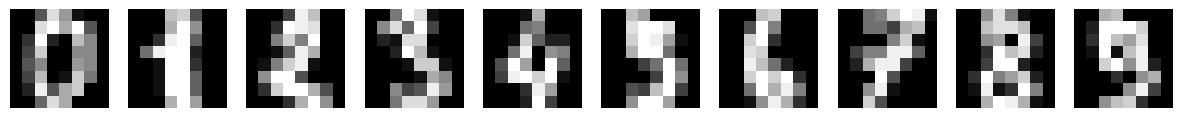

In [5]:
fig, axs = plt.subplots(ncols=10, figsize=(15, 4))
for i in range(10):
    axs[i].imshow(data[i].reshape((8, 8)), cmap="gray")
    axs[i].set_axis_off()

In [6]:
# Raw data is (0, 16), so scale to 8 bits (pillow can't handle 4-bit greyscale PNG depth)
scaler = MinMaxScaler(feature_range=(0, 255))
data = scaler.fit_transform(data).astype(np.uint8)

In [7]:
# Initialize to use t-SNE with 2 components (reduces data to 2 dimensions). Also note high overlap_percentage.
mapper = km.KeplerMapper(verbose=2)

# Fit and transform data
projected_data = mapper.fit_transform(data, projection=sklearn.manifold.TSNE())

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (1797, 64)

..Projecting data using: 
	TSNE(verbose=2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.000s...
[t-SNE] Computed neighbors for 1797 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 186.389054
[t-SNE] Computed conditional probabilities in 0.027s
[t-SNE] Iteration 50: error = 67.4767075, gradient norm = 0.0394655 (50 iterations in 0.174s)
[t-SNE] Iteration 100: error = 62.6647606, gradient norm = 0.0066735 (50 iterations in 0.161s)
[t-SNE] Iteration 150: error = 61.8393440, gradient norm = 0.0037447 (50 iterations in 0.162s)
[t-SNE] Iteration 200: error = 61.5371742, gradient norm = 0.0018445 (50 iterations in 0.162s)
[t-SNE] Iteration 250: error = 61.38835

In [8]:
projected_data.shape

(1797, 2)

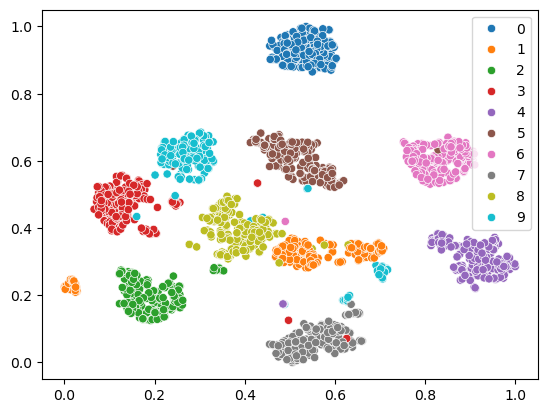

In [9]:
sns.scatterplot(
    x=projected_data[:, 0], y=projected_data[:, 1], hue=labels, palette="tab10"
)
plt.legend()
plt.show()

In [10]:
# Create the graph (we cluster on the projected data and suffer projection loss)
graph = mapper.map(
    projected_data,
    clusterer=sklearn.cluster.DBSCAN(eps=0.3, min_samples=15),
    cover=km.Cover(35, 0.4),
)

Mapping on data shaped (1797, 2) using lens shaped (1797, 2)

Minimal points in hypercube before clustering: 15
Creating 1225 hypercubes.
Cube_0 is empty.

   > Found 1 clusters in hypercube 1.
   > Found 1 clusters in hypercube 2.
Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

   > Found 1 clusters in hypercube 10.
   > Found 1 clusters in hypercube 11.
Cube_12 is empty.

Cube_13 is empty.

Cube_14 is empty.

Cube_15 is empty.

Cube_16 is empty.

Cube_17 is empty.

   > Found 1 clusters in hypercube 18.
   > Found 1 clusters in hypercube 19.
   > Found 1 clusters in hypercube 20.
   > Found 1 clusters in hypercube 21.
Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

   > Found 1 clusters in hypercube 25.
Cube_26 is empty.

Cube_27 is empty.

   > Found 1 clusters in hypercube 28.
Cube_29 is empty.

Cube_30 is empty.

   > Found 1 clusters in hypercube 31.
   > Found 1 clusters in hypercube 32.
   > 

In [11]:
# https://stackoverflow.com/questions/76147221/trying-to-fix-a-numpy-asscalar-deprecation-issue

import numpy


def patch_asscalar(a):
    return a.item()


setattr(numpy, "asscalar", patch_asscalar)

In [12]:
# Create images for a custom tooltip array
tooltip_s = []
for image_data in data:
    with io.BytesIO() as output:
        img = Image.fromarray(image_data.reshape((8, 8)), "L")
        img.save(output, "PNG")
        contents = output.getvalue()
        img_encoded = base64.b64encode(contents)
        img_tag = """<img src="data:image/png;base64,{}">""".format(
            img_encoded.decode("utf-8")
        )
        tooltip_s.append(img_tag)

tooltip_s = np.array(
    tooltip_s
)  # need to make sure to feed it as a NumPy array, not a list


# Create the visualizations (increased the graph_gravity for a tighter graph-look.)
print("Output graph examples to html")
# Tooltips with image data for every cluster member
mapper.visualize(
    graph,
    title="Handwritten digits Mapper",
    path_html="output/digits_custom_tooltips.html",
    color_values=labels,
    color_function_name="labels",
    custom_tooltips=tooltip_s,
    colorscale=[
        [
            i / 10,
            "rgb({}, {}, {})".format(int(c[0] * 255), int(c[1] * 255), int(c[2] * 255)),
        ]
        for i, c in enumerate(sns.color_palette("tab10", 11))
    ],
)
# Tooltips with the target y-labels for every cluster member
mapper.visualize(
    graph,
    title="Handwritten digits Mapper",
    path_html="output/digits_ylabel_tooltips.html",
    custom_tooltips=labels,
    colorscale=[
        [
            i / 10,
            "rgb({}, {}, {})".format(int(c[0] * 255), int(c[1] * 255), int(c[2] * 255)),
        ]
        for i, c in enumerate(sns.color_palette("tab10", 11))
    ],
)

Output graph examples to html
Wrote visualization to: output/digits_custom_tooltips.html
Wrote visualization to: output/digits_ylabel_tooltips.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Handwritten digits Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n